# MCMC Sampling

The  `CmdStanModel` class method  `sample` invokes Stan's adaptive HMC-NUTS
sampler which uses the Hamiltonian Monte Carlo (HMC) algorithm
and its adaptive variant the no-U-turn sampler (NUTS) to produce a set of
draws from the posterior distribution of the model parameters conditioned on the data.
It returns a `CmdStanMCMC` object
which provides properties to retrieve information about the sample, as well as methods
to run CmdStan's summary and diagnostics tools.

In order to evaluate the fit of the model to the data, it is necessary to run
several Monte Carlo chains and compare the set of draws returned by each.
By default, the `sample` command runs 4 sampler chains, i.e.,
CmdStanPy invokes CmdStan 4 times.
CmdStanPy uses Python's `subprocess` and `multiprocessing` libraries
to run these chains in separate processes.
This processing can be done in parallel, up to the number of
processor cores available.

## Prerequisites


CmdStanPy displays progress bars during sampling via use of package [tqdm](https://github.com/tqdm/tqdm).
In order for these to display properly, you must have the 
[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html) package installed,
and depending on your version of Jupyter or JupyterLab, you must enable it via command:

In [1]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu kernel kernelspec migrate nbconvert run
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


For more information, see the the
[installation instructions](https://ipywidgets.readthedocs.io/en/latest/user_install.html#), 
also [this tqdm GitHub issue](https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637).


    

## Fitting a model to data

In this example we use the CmdStan example model
[bernoulli.stan](https://github.com/stan-dev/cmdstanpy/blob/master/test/data/bernoulli.stan)
and data file
[bernoulli.data.json](https://github.com/stan-dev/cmdstanpy/blob/master/test/data/bernoulli.data.json>).

We instantiate a `CmdStanModel` from the Stan program file

In [2]:
import os
from cmdstanpy import CmdStanModel, cmdstan_path
    
bernoulli_dir = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
stan_file = os.path.join(bernoulli_dir, 'bernoulli.stan')
data_file = os.path.join(bernoulli_dir, 'bernoulli.data.json')

# instantiate, compile bernoulli model
model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:compiled model file: /home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli


By default, the model is compiled during instantiation.  The compiled executable is created in the same directory as the program file.  If the directory already contains an executable file with a newer timestamp, the model is not recompiled.

We run the sampler on the data using all default settings:  4 chains, each of which runs 1000 warmup and sampling iterations.

In [3]:
# run CmdStan's sample method, returns object `CmdStanMCMC`
fit = model.sample(data=data_file)

INFO:cmdstanpy:sampling: ['/home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli', 'id=1', 'random', 'seed=44666', 'data', 'file=/home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli.data.json', 'output', 'file=/tmp/tmp6ndnm29s/bernoulli-20211019133600-1-u90vky8_.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']


ERROR:cmdstanpy:Error in progress bar initialization:
	IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Disabling progress bars for this session


Exception ignored in: <function tqdm.__del__ at 0x7f00b824c1f0>
Traceback (most recent call last):
  File "/opt/hostedtoolcache/Python/3.9.7/x64/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/opt/hostedtoolcache/Python/3.9.7/x64/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Exception ignored in: <function tqdm.__del__ at 0x7f00b824c1f0>
Traceback (most recent call last):
  File "/opt/hostedtoolcache/Python/3.9.7/x64/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/opt/hostedtoolcache/Python/3.9.7/x64/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


INFO:cmdstanpy:start chain 3


INFO:cmdstanpy:start chain 4


INFO:cmdstanpy:sampling completed


The `sample` method returns a `CmdStanMCMC` object, which contains:
- metadata
- draws
- HMC tuning parameters `metric`, `step_size`

In [4]:
print('sampler diagnostic variables:\n{}'.format(fit.metadata.method_vars_cols.keys()))
print('stan model variables:\n{}'.format(fit.metadata.stan_vars_cols.keys()))

sampler diagnostic variables:
dict_keys(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'])
stan model variables:
dict_keys(['theta'])


In [5]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.30,0.0230,0.82,-8.900,-7.00,-6.70,1300.0,21000.0,1.0
theta,0.25,0.0032,0.12,0.074,0.24,0.47,1400.0,23000.0,1.0


The sampling data from the fit can be accessed either as a `numpy` array or a pandas `DataFrame`:

In [6]:
print(fit.draws().shape)
fit.draws_pd().head()

(1000, 4, 8)


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta
0,-7.46706,1.000000,0.928629,1.0,1.0,0.0,7.74438,0.123063
1,-6.81714,1.000000,0.928629,1.0,3.0,0.0,7.38157,0.205553
2,-6.90496,0.993293,0.928629,2.0,3.0,0.0,6.90842,0.184680
3,-6.82746,1.000000,0.928629,2.0,3.0,0.0,6.89321,0.202514
4,-6.75690,0.880840,0.928629,2.0,3.0,0.0,7.64382,0.233591


Additionally, if `xarray` is installed, this data can be accessed another way:

In [7]:
fit.draws_xr()

RuntimeError: Package "xarray" is not installed, cannot produce draws array.

The ``fit`` object records the command, the return code,
and the paths to the sampler output csv and console files.
The string representation of this object displays the CmdStan commands and
the location of the output files.

Output filenames are composed of the model name, a timestamp
in the form YYYYMMDDhhmm and the chain id, plus the corresponding
filetype suffix, either '.csv' for the CmdStan output or '.txt' for
the console messages, e.g. `bernoulli-201912081451-1.csv`. Output files
written to the temporary directory contain an additional 8-character
random string, e.g. `bernoulli-201912081451-1-5nm6as7u.csv`.

In [8]:
fit

CmdStanMCMC: model=bernoulli chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-1-u90vky8_.csv
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-2-wr72mp_5.csv
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-3-m_pdxmhw.csv
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-4-rknceq3w.csv
 output_files:
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-1-u90vky8_-stdout.txt
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-2-wr72mp_5-stdout.txt
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-3-m_pdxmhw-stdout.txt
	/tmp/tmp6ndnm29s/bernoulli-20211019133600-4-rknceq3w-stdout.txt

The sampler output files are written to a temporary directory which
is deleted upon session exit unless the ``output_dir`` argument is specified.
The ``save_csvfiles`` function moves the CmdStan CSV output files
to a specified directory without having to re-run the sampler.
The console output files are not saved. These files are treated as ephemeral; if the sample is valid, all relevant information is recorded in the CSV files.

### Sampler Progress

Your model make take a long time to fit.  The `sample` method provides two arguments:
    
- visual progress bar:  `show_progress=True`
- stream CmdStan ouput to the console - `show_console=True`
    
To illustrate how progress bars work, we will run the bernoulli model. Since the progress bars are only visible while the sampler is running and the bernoulli model takes no time at all to fit, we run this model for 200K iterations, in order to see the progress bars in action.

In [9]:
fit = model.sample(data=data_file, iter_warmup=100000, iter_sampling=100000, show_progress=True)


INFO:cmdstanpy:sampling: ['/home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli', 'id=1', 'random', 'seed=24823', 'data', 'file=/home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli.data.json', 'output', 'file=/tmp/tmp6ndnm29s/bernoulli-20211019133600-1-s8pwqv99.csv', 'method=sample', 'num_samples=100000', 'num_warmup=100000', 'algorithm=hmc', 'adapt', 'engaged=1']


INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:start chain 2


INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:start chain 3


INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:start chain 4


INFO:cmdstanpy:finish chain 4


INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:sampling completed


The Stan language `print` statement can be use to monitor the Stan program state.
In order to see this information as the sampler is running, use the `show_console=True` argument.
This will stream all CmdStan messages to the terminal while the sampler is running.


In [10]:
fit = model.sample(data=data_file, chains=2, parallel_chains=1, show_console=True)



INFO:cmdstanpy:sampling: ['/home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli', 'id=1', 'random', 'seed=48639', 'data', 'file=/home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli.data.json', 'output', 'file=/tmp/tmp6ndnm29s/bernoulli-20211019133607-1-dn90ftr5.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']


INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:start chain 2


INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:sampling completed


chain 1: method = sample (Default)
chain 1: sample
chain 1: num_samples = 1000 (Default)
chain 1: num_warmup = 1000 (Default)
chain 1: save_warmup = 0 (Default)
chain 1: thin = 1 (Default)
chain 1: adapt
chain 1: engaged = 1 (Default)
chain 1: gamma = 0.050000000000000003 (Default)
chain 1: delta = 0.80000000000000004 (Default)
chain 1: kappa = 0.75 (Default)
chain 1: t0 = 10 (Default)
chain 1: init_buffer = 75 (Default)
chain 1: term_buffer = 50 (Default)
chain 1: window = 25 (Default)
chain 1: algorithm = hmc (Default)
chain 1: hmc
chain 1: engine = nuts (Default)
chain 1: nuts
chain 1: max_depth = 10 (Default)
chain 1: metric = diag_e (Default)
chain 1: metric_file =  (Default)
chain 1: stepsize = 1 (Default)
chain 1: stepsize_jitter = 0 (Default)
chain 1: num_chains = 1 (Default)
chain 1: id = 1 (Default)
chain 1: data
chain 1: file = /home/runner/.cmdstan/cmdstan-2.28.0/examples/bernoulli/bernoulli.data.json
chain 1: init = 2 (Default)
chain 1: random
chain 1: seed = 48639
chain 1

## Running a data-generating model

In this example we use the CmdStan example model
[data_filegen.stan](https://github.com/stan-dev/cmdstanpy/blob/master/docs/notebooks/data_filegen.stan)
to generate a simulated dataset given fixed data values.

In [11]:
model_datagen = CmdStanModel(stan_file='bernoulli_datagen.stan')
datagen_data = {'N':300, 'theta':0.3}
fit_sim = model_datagen.sample(data=datagen_data, fixed_param=True)
fit_sim.summary()

INFO:cmdstanpy:compiling stan program, exe file: /home/runner/work/cmdstanpy/cmdstanpy/docsrc/examples/bernoulli_datagen


INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}


INFO:cmdstanpy:compiled model file: /home/runner/work/cmdstanpy/cmdstanpy/docsrc/examples/bernoulli_datagen


INFO:cmdstanpy:sampling: ['/home/runner/work/cmdstanpy/cmdstanpy/docsrc/examples/bernoulli_datagen', 'id=1', 'random', 'seed=96469', 'data', 'file=/tmp/tmp6ndnm29s/tx9uh4p9.json', 'output', 'file=/tmp/tmp6ndnm29s/bernoulli_datagen-20211019133614-1-qaadjn46.csv', 'method=sample', 'algorithm=fixed_param']


INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:sampling completed


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0,NaN,0,0,0,0.0,NaN,NaN,NaN
theta_rep,90,0.27,8,77,90,100.0,860.0,120000.0,1.0


Compute, plot histogram of total successes for `N` Bernoulli trials with chance of success `theta`:

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.


INFO:matplotlib.font_manager:generated new fontManager


<AxesSubplot:ylabel='Frequency'>

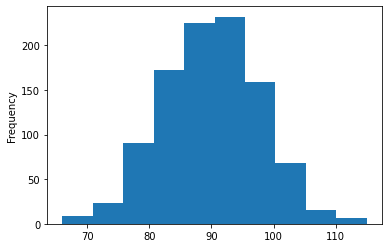

In [12]:
drawset_pd = fit_sim.draws_pd()
drawset_pd.columns

# restrict to columns over new outcomes of N Bernoulli trials
y_sims = drawset_pd.drop(columns=['lp__', 'accept_stat__'])

# plot total number of successes per draw
y_sums = y_sims.sum(axis=1)
y_sums.astype('int32').plot.hist(range(0,datagen_data['N']+1))